<hr style="border-width:4px; border-style:solid; border-color:coral"/>

# Data Assimilation using the  representer method
<hr style="border-width:4px; border-style:solid; border-color:coral"/>


The notebook solves the scalar advection equation, given by the partial differential equation

\begin{equation}
q_t + u q_x = 0
\end{equation}

where $u$ is a prescribed velocity field.  This equation models, for example, the transport of a tracer field in a background flow.  

We solve this problem in the periodic domain $x \in [0,1]$ over the time interval $t \in [0,T_{final}]$.  We set the velocity field to $u=1$. 

Observed data values are assimilated into the calculation to improve the model to more accurately predict the observed values.

In this notebook, we use exact solutions for the representers, so don't require any numerical integration.  

In [1]:
%matplotlib notebook
%pylab

Using matplotlib backend: nbAgg
Populating the interactive namespace from numpy and matplotlib


<hr style="border-width:4px; border-style:solid; border-color:coral"/>

## Problem parameters

In [2]:
# Domain [ax,bx]
ax = 0
bx = 1

# Velocity (constant in this example)
u = 1

# Final time
T_final = 1.0

# Concentration profile used for initial conditions and exact solution.
def concentration(x):
    r = abs(x-0.25)
    r0 = 0.25
    return 0*where(r < r0,exp(-160*r**2),0)

### User supplied numerical parameters

In [3]:
# Number of grid points on cell centered mesh
mx = 512

# Number of time steps.  We can specify this here since we don't do any time stepping with
# a discrete system.  
M = 128

### Weights for the model, initial conditions and boundary conditions
Values for model and initial condition weights.   The functions defined below depend on these values, so are included in the same cell. 

In [4]:
# Functions defined here require values for eps, Cf and Ci. 

# Smaller values suggest (model, initial conditions, BCs) are trusted.  
# Larger values suggest these items are not trusted. 

Cf = 100   # Model weights
Ci = 0.01     # Initial conditions
Cb = 1      # Not yet used

# Sharpness of the delta function (1e-3 = not very sharp; 1e-5 = sharp)
eps = 1e-3

# Initial condition for unforced solution u_F
def initial_condition(x):
    return concentration(x)

def qexact(x,t):
    return concentration(x-u*t)

# Discrete delta function
def delta(x):
    return exp(-x**2/(4*eps))/sqrt(4*pi*eps)

# Use Duhamel's Principle to compute the solution to the adjoint alpha_m and 
# representer r_m
def adjoint(x,t,xm,tm):
    a = mod(x-xm - u*(t-tm),1)
    dc = where(a < 0.5,delta(a),delta(a-1))
    return where(t < tm,dc,0)  

def representer(x,t,xm,tm):
    a0 = adjoint(x-u*t,0,xm,tm)  # Initial condition
    a = mod(x-xm-u*(t-tm),1)
    dc = where(a < 0.5,delta(a),delta(a-1))
    return Ci*a0 + Cf*dc*where(t < tm, t,tm)

<hr style="border-width:4px; border-style:solid; border-color:coral"/>

## Measurements and weights

We create obseverable data triples `(xm,tm,dm,winv)` using a random number generator.
The data values are taken to be perturbations to an exactly defined solution for the unforced scalar advection problem.

In [5]:
# Build data triples : (xm,tm,dm,winv)

# Number of observables
mdata = 5

# Measurements : Spatial location in [ax,bx] (uniform random locations)
xm_data = ax + (bx-ax)*random.rand(mdata)

# Measurements : temporal locations (uniform random time values)
tm = T_final*random.rand()
# tm = 0.331
# tm_data = array([tm]*mdata)    # Measurements all taken at the same time.
tm_data = T_final*random.rand(mdata)               # Measurements taken at different times

# tm = 0.5

Construct measured values, based on noise.

In [6]:
# Noise in the data : wnoise*randn() 
wnoise = 0.25

# Measurements : Normally distributed perturbations to "perfect" data
dm_data = empty(mdata)
for j in range(0,mdata):
    dm_data[j] = concentration(xm_data[j]-u*tm_data[j]) + wnoise*abs(random.randn())

Supply data weights for each data point. Trusted data is given a large weight (small inverse) and untrusted data is given a small weight (large inverse). 

In [7]:
# Weights on data ("w")   (??)
c = cov(dm_data)
wminv = c*ones(mdata)     # Default : Assume data is near perfect

# Adjust some of the weights for imperfect data (turned off if "False" included)
if mdata > 5 and False:
    wminv[2] = 100   # Data should not be trusted 
    wminv[3] = 10    
    wminv[4] = 1
    wminv[5] = 0.01  # Data is trusted    

Create list of data tuples

In [8]:
# Create list of tuples
data = list(zip(xm_data,tm_data,dm_data,wminv)) 

In [9]:
# This will retrieve data used in the proposal figures
import pickle
pickle.dump(data, open('fig_data.dump', 'wb'))
fig_data = pickle.load(open('fig_data.dump', 'rb'))
fig_data

[(0.9656190384623687,
  0.30741822509238026,
  0.012995437563529237,
  0.04393391485878259),
 (0.37679485668277624,
  0.9499117761990865,
  0.045663589447865104,
  0.04393391485878259),
 (0.5319314172450834,
  0.07751245851967281,
  0.2790040298401484,
  0.04393391485878259),
 (0.6303329930388646,
  0.22809421829254684,
  0.24941794076406057,
  0.04393391485878259),
 (0.3143636959254722,
  0.0960523612025197,
  0.5334145970198749,
  0.04393391485878259)]

In [10]:
data

[(0.9656190384623687,
  0.30741822509238026,
  0.012995437563529237,
  0.04393391485878259),
 (0.37679485668277624,
  0.9499117761990865,
  0.045663589447865104,
  0.04393391485878259),
 (0.5319314172450834,
  0.07751245851967281,
  0.2790040298401484,
  0.04393391485878259),
 (0.6303329930388646,
  0.22809421829254684,
  0.24941794076406057,
  0.04393391485878259),
 (0.3143636959254722,
  0.0960523612025197,
  0.5334145970198749,
  0.04393391485878259)]

<hr style="border-width:4px; border-style:solid; border-color:coral"/>

## Set up numerical mesh

Define the spatial cell-centered mesh and time step size, and number of time steps.

In [11]:
# Mesh cell size
dx = (bx-ax)/mx

# Time step
dt = T_final/M

# Generate spatial meshes
xe = linspace(ax,bx,mx+1)
xc = xe[:-1] + dx/2

# Temporal mesh
tv = linspace(0,T_final,M+1)

<hr style="border-width:4px; border-style:solid; border-color:coral"/>

## Compute representers and least squared solution $\widehat{u}(x,t)$

We use an exact solution for the representers. 

In [12]:
R = zeros((mdata,mdata))
h = zeros(mdata)

# Compute R using exact solution
for j,dj in enumerate(data):
    # dj = data[j]
    xm = dj[0]
    tm = dj[1]
    dm = dj[2]
    for i,d in enumerate(data):
        R[i,j] = representer(d[0],d[1],xm,tm)
        
    # Use exact solution to get Uf entries
    uf = qexact(xm,tm)    
    
    # Construct right hand side    
    h[j] = dm - uf

# Create matrix of weights.  Use diagonal weighting
wm = [w[3] for w in data]
W_inv = diag(wm)
    
# Solve for beta values
P = R + W_inv
beta = linalg.solve(P,h)

# Construct least squares fit Uhat
Uhat = zeros((mx,M+1))
for n in range(0,M+1):
    t = tv[n]
    uhat = qexact(xc,t)
    for j,d in enumerate(data):       
        rmd = representer(xc,t,d[0],d[1])
        uhat += beta[j]*rmd
    Uhat[:,n] = uhat

print("Done computing Uhat")
print("\nR matrix : ")
f = {'all' : lambda x : "{:12.6f}".format(x)}
with np.printoptions(precision=6, suppress=True, formatter=f,linewidth=100):
    print(R)
    
print("\nbeta vector:")
f = {'all' : lambda x : "{:12.4e}".format(x)}
with np.printoptions(precision=6, suppress=True, formatter=f,linewidth=100):
    print(beta)

Done computing Uhat

R matrix : 
[[  274.325341     0.000425     0.002146     0.000016     0.000000]
 [    0.000425   847.469460    57.280041   174.887354     0.001622]
 [    0.002146    57.280041    69.235129    35.051398     0.000061]
 [    0.000016   174.887354    35.051398   203.563404     0.018213]
 [    0.000000     0.001622     0.000061     0.018213    85.773873]]

beta vector:
[  4.7335e-05  -3.9368e-04   3.9020e-03   8.9085e-04   6.2155e-03]


We can check the values of the functional in this case.  See Bennet, page 22, and page 43

In [13]:
W = diag(1/wminv)

# From Bennet, page 22 (Exercise 1.3.3 and 1.3.4)
print("From Bennet, page 23")
JuF = h.transpose()@W@h
print("J[uF] = {:.4e}".format(JuF))

Juhat = h.transpose()@beta
print("J[uhat] = {:.4e}".format(Juhat))

Jdata = beta.transpose()@W_inv@beta
print("Jdata = {:.4e}".format(Jdata))

Jmod = Juhat - Jdata
print("Jmodel = {:.8e}".format(Jmod))

print("\nFrom Bennet, page 44")
T = sqrt(W)@R@sqrt(W)
print("EJF = {:.8e}".format(trace(T) + mdata))

# From Bennet, page 44 (Exercise 2.3.2)
Pinv = inv(P)
T = sqrt(W_inv)@Pinv@sqrt(W_inv)
print("EJdata = {:.8e}".format(trace(T)))

From Bennet, page 23
J[uF] = 9.7154e+00
J[uhat] = 4.6089e-03
Jdata = 2.4080e-06
Jmodel = 4.60653077e-03

From Bennet, page 44
EJF = 3.37003174e+04
EJdata = 1.71849217e-03


<hr style="border-width:4px; border-style:solid; border-color:coral"/>

## Plot the inverse $\widehat{u}(x,t)$
Plot the least squares solution (the inverse "uhat").   Along with the solution, we also plot the data points and show that the data points are approximately interpolated, depending on how the weights are set. 

<IPython.core.display.Javascript object>


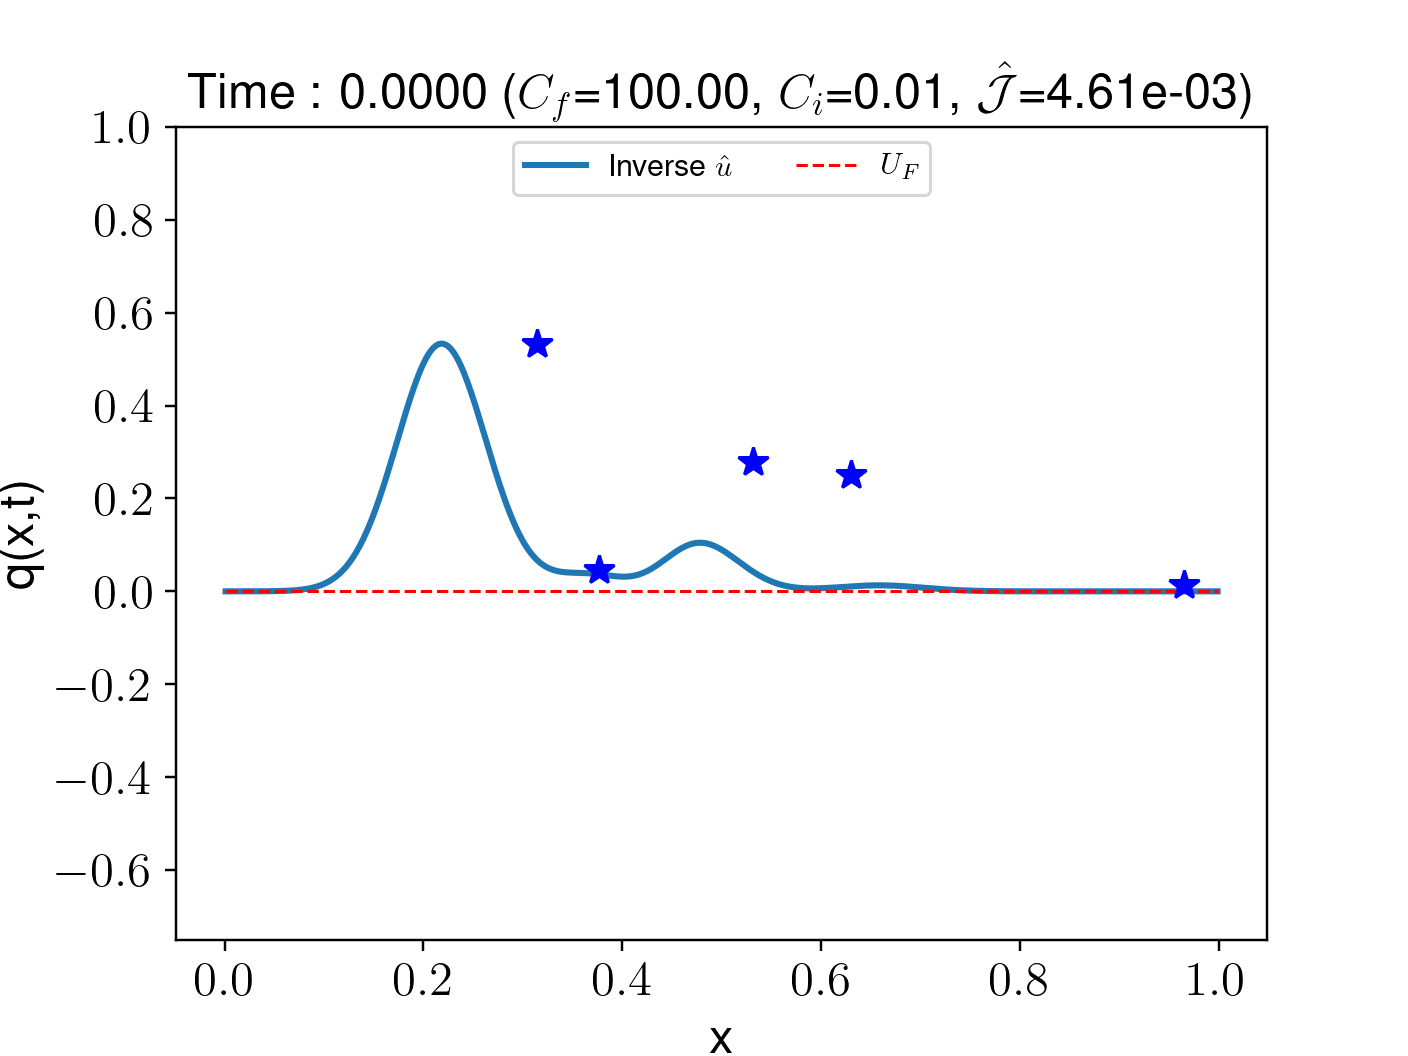

In [14]:
fig = figure(1)
clf()


rcParams.update({"text.usetex": True,
     "text.latex.preamble": r"\usepackage{amsmath,amsfonts,amssymb}",
     "font.family": "sans-serif",
     "font.sans-serif": ["Helvetica"]})



font = {'family': 'sans-serif',
        'color':  'black',
        'weight': 'normal',
        'size': 16
        }

import matplotlib.font_manager as font_manager
font_prop = font_manager.FontProperties(fname="Helvetica", size=16)

# Evaluate initial conditions
q = Uhat[:,0]

# Plot initial solution and store handle
hdl, = plot(xc,q,linewidth=2,label='Inverse $\hat{{u}}$')
#title_str = 'Time : {:.4f} ($C_f$={:.2f}, $C_i$={:.2f}) (legend=$x_m$,$t_m$,$d_m$,$w_m^{{-1}}$)'
title_str = r'Time : {:.4f} ($C_f$={:.2f}, $C_i$={:.2f}, $\hat{{\mathcal J}}$={:.2e})'
htitle = title(title_str.format(0,Cf,Ci,Juhat),fontsize=16)

t = 0
d = initial_condition(xc)
hdl_exact, = plot(xc,d,'r--',linewidth=1,label='$U_F$')

xlabel('x',fontdict=font)
ylabel('q(x,t)', fontdict=font)

hdl_data = [None]*mdata
for j,d in enumerate(data):
    xm = d[0]
    tm = d[1]
    dm = d[2]
    wm = d[3]
    str = '({:.2f},{:.2f},{:.2f},{:.2f})'.format(xm,tm,dm,wm)
    hdl_data[j], = plot(xm,dm,'#888888',marker='*',markersize=10)   # ,label=str)

for label in gca().get_xticklabels() :
    label.set_fontproperties(font_prop)
for label in gca().get_yticklabels() :
    label.set_fontproperties(font_prop)

    
ylim([-0.75,2.2])
legend(loc='upper left',ncol=1)

fig.canvas.draw()        
# pause(1)
# savefig("init_02.png")

hit_data = zeros(mdata)
for n in range(0,M+1):  
    t = tv[n]
    q = Uhat[:,n]
    hdl.set_ydata(q)
    
    # Update title with new time
    # htitle.set_text(title_str.format(t,Cf,Ci,Juhat))
    
    # Plot unforced solution u_F
    d = qexact(xc, t)
    hdl_exact.set_ydata(d)

    # Change the color of any data points we hit 
    for j,d in enumerate(data):
        tm = d[1]
        if (tm <= t and t < tm + dt):
            hdl_data[j].set_color('r')
            hit_data[j] = 1
        elif hit_data[j] == 1:
            hdl_data[j].set_color('b')
            hit_data[j] = 2

    ylim([-0.75,1])

    # Add legend; refresh plot
    legend(loc='upper center',ncol=2)
    #legend(loc='upper left')
    fig.canvas.draw()        
    
    if n == 64:
        pass
        # pause(1)
        # savefig("tmid_02.png")
    
    if any(hit_data == 1):
        # pass
        # Pause when solution hits a data point
        pause(0.5)
        # savefig("tm_02.png")

